In [296]:
import pandas as pd
import numpy as np
import pylab as pl
import geopandas as gpd
import os
import scipy
from scipy.interpolate import griddata as gd
import statsmodels.formula.api as smf
import laspy
from fiona.crs import from_epsg
from geopandas.tools import sjoin
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics, cross_validation
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [297]:
path = os.getenv('PUIDATA')

In [298]:
oil_data = pd.read_csv(path+'/Oil_Boilers_-_Detailed_Fuel_Consumption_and_Building_Data.csv')

In [299]:
oil_data = oil_data.drop([ 'Facility Address', 'Borough',
       'Community Board',
       'Council District','NTA',
       'Natural Gas Utility (Con Edison or National Grid', 'DEP Boiler Application #',
       'Deadline for phasing out #6 oil (i.e. data of next DEP permit renewal after July 1 2012)',
       'Boiler Model', 'Number of identical boilers','Boiler Installation Date',
       'Estimated retirement date of boiler (assuming 35 year average useful life)',
       'Is boiler dual fuel capable?',
       'Total Estimated Cosumption - Low Estimate (Gallons) ',
       'Total Estimated Cosumption - High Estimate (MMBTUs) ',
       'Total Estimated Cosumption - Low Estimate  (MMBTUs) ',
       'Deadline for complying with Audit and Retrocommissioning Law',
         'City Council District','Number of total units',
       'Total area of buildings on lot',
       'Number of buildings on property (tax lot)', 'Number of floors',
       'Year constructed', 'Condominium housing?', 'Cooperative housing?','Building Manager', 
                          'Owner', 'Owner Address'],axis=1)

In [300]:
oil_data.head()

,"BBL (Borough, Block and Lot)",Postcode,Latitude,Longitude,Census Tract,BIN,Boiler capacity (Gross BTU),Age range of boiler,Burner Model,Primary Fuel,Total Estimated Cosumption - High Estimate (Gallons),Needs to comply with Greener Greater Buildings Laws?,Building Type,Number of residential units
0,1007910062,NaN,NaN,NaN,NaN,NaN,2.80,31 to 35 years old,INDUSTRIAL COMBUSTION MEG-34S,#6,32016,NaN,Office Buildings,42
1,1012440072,NaN,NaN,NaN,NaN,NaN,14.00,26 to 30 years old,ICI DEG 175 P,#6,146000,Yes,Elevator Apartments,87
2,2025080024,NaN,NaN,NaN,NaN,NaN,2.80,Over 50 years,HEV-E-OIL AL4C,#4,30814,NaN,Elevator Apartments,30
3,2029900034,10460.0,40.835731,-73.886595,161.0,2010678.0,2.60,26 to 30 years old,HEV-E-OIL AMG 4 3/4,#4,25309,NaN,Loft Buildings,26
4,2024720028,NaN,NaN,NaN,NaN,NaN,2.59,21 to 26 years old,ICI - MMG 30,#4,25000,NaN,Elevator Apartments,36


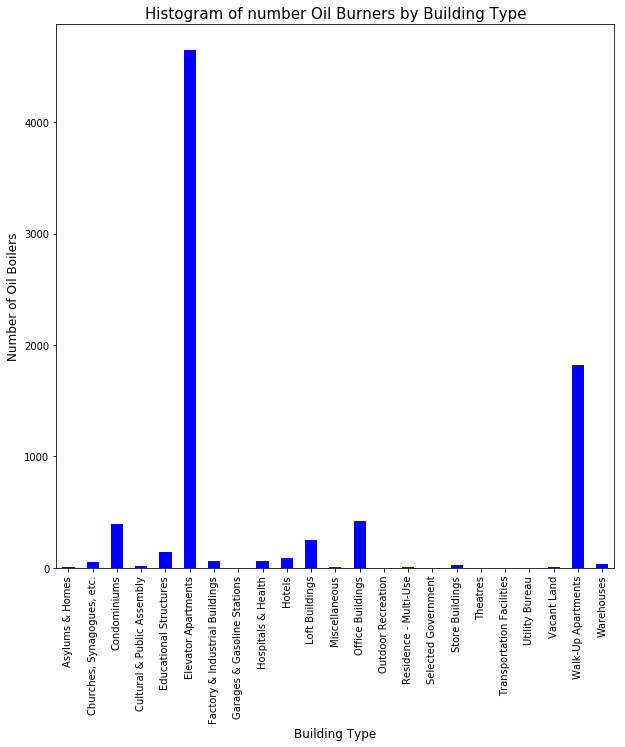

In [306]:
ax=pl.figure(figsize=(10,10))
ax1= ((oil_data['Total Estimated Cosumption - High Estimate (Gallons) '].groupby(oil_data['Building Type'])\
       .count().plot(kind="bar",color='blue')))
ax1.set_title('Histogram of number Oil Burners by Building Type', fontsize=15)
ax1.set_ylabel('Number of Oil Boilers', fontsize=12)
ax1.set_xlabel('Building Type', fontsize=12);

#### Fig1: This figure gives us the Count of Oil Burners by Building Type across the city

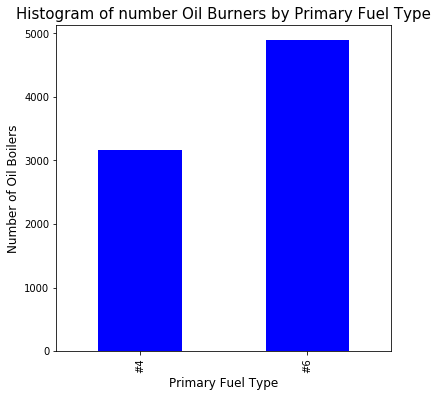

In [310]:
ax=pl.figure(figsize=(6,6))
ax1= ((oil_data['Total Estimated Cosumption - High Estimate (Gallons) '].groupby(oil_data['Primary Fuel']).\
       count().plot(kind="bar",color='blue')))
ax1.set_title('Histogram of number Oil Burners by Primary Fuel Type', fontsize=15)
ax1.set_ylabel('Number of Oil Boilers', fontsize=12)
ax1.set_xlabel('Primary Fuel Type', fontsize=12);


#### Fig 2: This figure gives us the count of oil boilers by the primary fuel type

## Reading Benchmarking Data

In [311]:
bmark = pd.read_csv(path+'/nyc_benchmarking_disclosure_data_reported_in_2016.csv')

In [312]:
bmark = bmark.drop(['Unnamed: 0', 'Record Number', 'Order',
        'Co-reported BBL Status',
       'BBLs Co-reported',
        'Property Name',
       'Parent Property Id', 'Parent Property Name', 'Street Number',
       'Street Name', 'Borough',
       'DOF Benchmarking Submission Status',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)', 'ENERGY STAR Score',
        'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Source EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
         'District Steam Use (kBtu)',
       'District Hot Water Use (kBtu)', 'District Chilled Water Use (kBtu)',
       'Natural Gas Use (kBtu)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Weather Normalized Site Electricity (kWh)',
       'DOF Property Floor Area (ft²)', 'Property GFA - Self-reported (ft²)',
       'Water Use (All Water Sources) (kgal)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Release Date', 'DEP Provided Water Use (kgal)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method'],axis=1)

In [313]:
bmark.head()

,"NYC Borough, Block and Lot (BBL)",Reported NYC Building Identification Numbers (BINs),Zip Code,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,1.003360e+09,1088884,10002.0,Multifamily Housing,73.7,Not Available,Not Available,Not Available,Not Available,Not Available,436.3,290.2,146.1
1,1.010618e+09,1026728,10019.0,Multifamily Housing,51.3,Not Available,Not Available,Not Available,Not Available,Not Available,201.4,76.4,125.0
2,1.014270e+09,1043974,10021.0,Multifamily Housing,44.9,Not Available,Not Available,Not Available,Not Available,Not Available,538.4,145.5,392.9
3,1.015180e+09,1048117,10128.0,Multifamily Housing,91.3,Not Available,Not Available,Not Available,Not Available,Not Available,699.3,304.6,394.7
4,1.003920e+09,1079685,10009.0,Residence Hall/Dormitory,NaN,Not Available,Not Available,Not Available,Not Available,Not Available,0.0,0.0,0.0


## Reading census data

In [321]:
mhi_data = pd.read_csv(path+'/ACS_16_5YR_S1901_with_ann.csv')

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [324]:
mhi_data = mhi_data.drop([0])

In [326]:
mhi_data = mhi_data[['GEO.id','GEO.id2','GEO.display-label','HC01_EST_VC01']]

In [327]:
mhi_data.head()

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC01
1,1400000US36001000100,36001000100,"Census Tract 1, Albany County, New York",843
2,1400000US36001000200,36001000200,"Census Tract 2, Albany County, New York",2049
3,1400000US36001000300,36001000300,"Census Tract 3, Albany County, New York",2324
4,1400000US36001000401,36001000401,"Census Tract 4.01, Albany County, New York",1016
5,1400000US36001000403,36001000403,"Census Tract 4.03, Albany County, New York",2294


### Reading Zip-Tract relationship file

In [328]:
tract = pd.read_csv(path+'/ZIP_TRACT_122016.csv')

In [329]:
census_data = pd.merge(mhi_data, tract, left_on=mhi_data['GEO.id2'], right_on=tract.TRACT)

In [330]:
census_data.head()

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC01,Unnamed: 0,ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,1400000US36091062700,36091062700,"Census Tract 627, Saratoga County, New York",2651,17562,12188,36091062700,0.554195,0.380952,0.398649,0.544356
1,1400000US36091062800,36091062800,"Census Tract 628, Saratoga County, New York",989,17561,12188,36091062800,0.201325,0.369048,0.533784,0.215931
2,1400000US36093020101,36093020101,"Census Tract 201.01, Schenectady County, New York",1130,17753,12308,36093020101,0.211167,0.063694,0.214765,0.205514
3,1400000US36093020101,36093020101,"Census Tract 201.01, Schenectady County, New York",1130,17762,12309,36093020101,0.024028,0.009042,0.012552,0.023220
4,1400000US36093020102,36093020102,"Census Tract 201.02, Schenectady County, New York",1020,17751,12308,36093020102,0.134621,0.057325,0.051454,0.126850


In [331]:
census_data = census_data.groupby(census_data.ZIP).mean()

In [333]:
census_data.reset_index(inplace=True)

In [334]:
census_data.head()

,ZIP,Unnamed: 0,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,501,0.0,3.610316e+10,0.000000,1.000000,0.000000,1.000000
1,6390,7472.0,3.610317e+10,1.000000,1.000000,0.000000,1.000000
2,10466,12981.0,3.611900e+10,0.000743,0.000000,0.000574,0.000698
3,10470,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
4,10475,13128.0,3.611901e+10,0.000000,0.001212,0.000000,0.000044


In [335]:
bmark['Zip Code'] = bmark['Zip Code'].astype(float)
census_data.ZIP = census_data.ZIP.astype(float)

In [336]:
census_bmark = pd.merge(bmark, census_data, left_on=bmark['Zip Code'] , right_on=census_data.ZIP )

In [339]:
census_bmark.head()

,"NYC Borough, Block and Lot (BBL)",Reported NYC Building Identification Numbers (BINs),Zip Code,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),ZIP,Unnamed: 0,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,2.033630e+09,2018704,10470.0,Multifamily Housing,72.2,Not Available,Not Available,Not Available,Not Available,Not Available,331.8,238.7,93.1,10470.0,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
1,2.033680e+09,2018858,10470.0,Multifamily Housing,58.3,Not Available,7069284.5,Not Available,Not Available,Not Available,662.1,544.5,117.6,10470.0,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
2,2.033800e+09,2019289,10470.0,Multifamily Housing,116.9,Not Available,3381000.1,Not Available,Not Available,Not Available,446.9,411.3,35.5,10470.0,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
3,2.033820e+09,2019330,10470.0,Multifamily Housing,93.3,Not Available,Not Available,4160416.1,Not Available,Not Available,359.3,317.8,41.5,10470.0,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
4,2.033830e+09,2019336,10470.0,Multifamily Housing,98.9,Not Available,824411.9,Not Available,Not Available,Not Available,643.8,508.7,135.2,10470.0,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328


In [338]:
census_bmark = census_bmark[census_bmark['Primary Property Type - Self Selected'] == 'Multifamily Housing']

In [340]:
print ("Are there missing values? -->", census_bmark['Total GHG Emissions (Metric Tons CO2e)'].isnull().values.any())
print ("There are %i missing values out of %i properties (%.1f percent)" %(census_bmark['Total GHG Emissions (Metric Tons CO2e)'].isnull().sum(), 
                                                                        len(census_bmark), 
                                                                        census_bmark['Total GHG Emissions (Metric Tons CO2e)'].isnull().sum()
                                                                          /float(len(census_bmark))*100))

Are there missing values? --> True
There are 1 missing values out of 55 properties (1.8 percent)


In [342]:
# Drop nans
census_bmark = census_bmark.dropna(subset=['Total GHG Emissions (Metric Tons CO2e)'])
print ('Examples after dropping NaNs:', len(census_bmark))

Examples after dropping NaNs: 54


In [344]:
# Drop zero EUI values
census_bmark = census_bmark[census_bmark['Total GHG Emissions (Metric Tons CO2e)']>0]
print ('Examples after dropping zeros:', len(census_bmark))

Examples after dropping zeros: 54


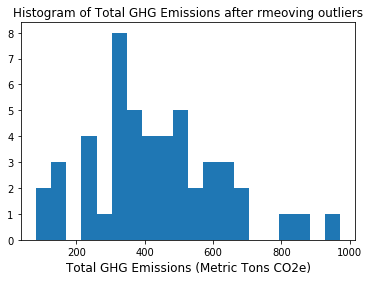

In [351]:
pl.hist(census_bmark['Total GHG Emissions (Metric Tons CO2e)'][census_bmark['Total GHG Emissions (Metric Tons CO2e)']<1000], bins=20)
pl.xlabel('Total GHG Emissions (Metric Tons CO2e)',fontsize=12)
pl.title('Histogram of Total GHG Emissions after rmeoving outliers')
pl.show()

## Merging oil and benchmarking data

In [314]:
merged_data = pd.merge(oil_data, bmark, left_on='BBL (Borough, Block and Lot)', right_on='NYC Borough, Block and Lot (BBL)',how='outer')

In [315]:
oil_bmark = merged_data
geo_data = merged_data

In [316]:
oil_bmark.head()

,"BBL (Borough, Block and Lot)",Postcode,Latitude,Longitude,Census Tract,BIN,Boiler capacity (Gross BTU),Age range of boiler,Burner Model,Primary Fuel,...,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,1.007910e+09,NaN,NaN,NaN,NaN,NaN,2.8,31 to 35 years old,INDUSTRIAL COMBUSTION MEG-34S,#6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.012440e+09,NaN,NaN,NaN,NaN,NaN,14.0,26 to 30 years old,ICI DEG 175 P,#6,...,Multifamily Housing,76.1,Not Available,Not Available,14013371.4,Not Available,Not Available,1393.5,1082.0,311.5
2,2.025080e+09,NaN,NaN,NaN,NaN,NaN,2.8,Over 50 years,HEV-E-OIL AL4C,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.025080e+09,NaN,NaN,NaN,NaN,NaN,1.7,11 to 15 years old,ICI MMG 22,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.029900e+09,10460.0,40.835731,-73.886595,161.0,2010678.0,2.6,26 to 30 years old,HEV-E-OIL AMG 4 3/4,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [317]:
oil_bmark.columns

Index(['BBL (Borough, Block and Lot)', 'Postcode', 'Latitude', 'Longitude',
       'Census Tract', 'BIN', 'Boiler capacity (Gross BTU)',
       'Age range of boiler', 'Burner Model', 'Primary Fuel',
       'Total Estimated Cosumption - High Estimate (Gallons) ',
       'Needs to comply with Greener Greater Buildings Laws?', 'Building Type',
       'Number of residential units', 'NYC Borough, Block and Lot (BBL)',
       'Reported NYC Building Identification Numbers (BINs)', 'Zip Code',
       'Primary Property Type - Self Selected', 'Site EUI (kBtu/ft²)',
       'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)', 'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)'],
      dtype='object')

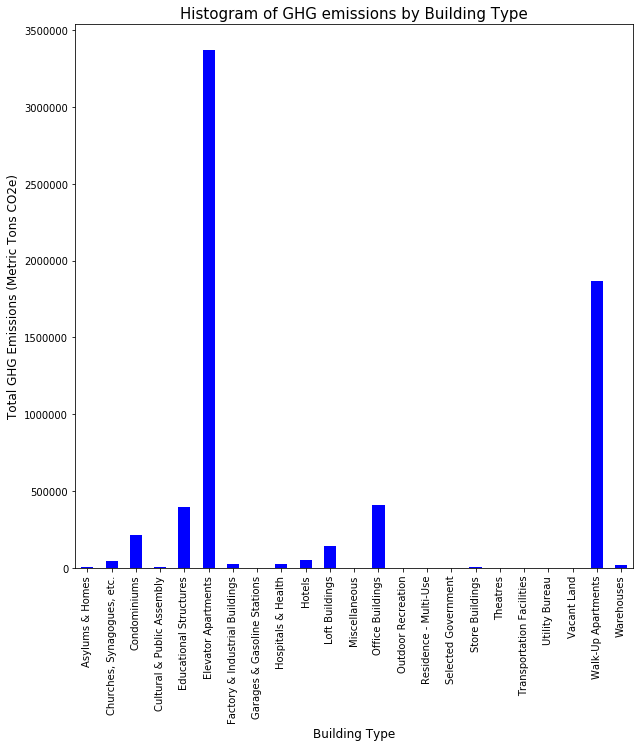

In [319]:
ax=pl.figure(figsize=(10,10))
ax1= ((oil_bmark['Total GHG Emissions (Metric Tons CO2e)'].groupby(oil_bmark['Building Type']).sum()\
       .plot(kind="bar",color='blue')))
ax1.set_title('Histogram of GHG emissions by Building Type', fontsize=15)
ax1.set_ylabel('Total GHG Emissions (Metric Tons CO2e)', fontsize=12)
ax1.set_xlabel('Building Type', fontsize=12);


#### Fig 3: This figure gives the GHG emissions by the building type

In [251]:
oil_bmark = oil_bmark.rename(columns={'Total Estimated Cosumption - High Estimate (Gallons) ':'Estimated_Consumption'
                                           , 'Total GHG Emissions (Metric Tons CO2e)':'Total_GHG'
                                           , 'Number of residential units':'Res_Units'})

In [252]:
oil_bmark = oil_bmark.dropna()

In [253]:
oil_bmark.columns

Index(['BBL (Borough, Block and Lot)', 'Postcode', 'Latitude', 'Longitude',
       'Census Tract', 'BIN', 'Boiler capacity (Gross BTU)',
       'Age range of boiler', 'Burner Model', 'Primary Fuel',
       'Estimated_Consumption',
       'Needs to comply with Greener Greater Buildings Laws?', 'Building Type',
       'Res_Units', 'NYC Borough, Block and Lot (BBL)',
       'Reported NYC Building Identification Numbers (BINs)', 'Zip Code',
       'Primary Property Type - Self Selected', 'Site EUI (kBtu/ft²)',
       'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)', 'Total_GHG',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)'],
      dtype='object')

In [254]:
oil_bmark = oil_bmark.drop(['BBL (Borough, Block and Lot)', 'Postcode', 'Latitude', 'Longitude',
       'Census Tract', 'BIN','Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)','Burner Model','Primary Property Type - Self Selected',
    'NYC Borough, Block and Lot (BBL)','Reported NYC Building Identification Numbers (BINs)',
                           'Age range of boiler','Needs to comply with Greener Greater Buildings Laws?',
                          'Building Type','Direct GHG Emissions (Metric Tons CO2e)',
                           'Indirect GHG Emissions (Metric Tons CO2e)'], axis=1)

In [255]:
oil_bmark = oil_bmark.reset_index()
del oil_bmark['index']

In [256]:
oil_bmark.head()

,Boiler capacity (Gross BTU),Primary Fuel,Estimated_Consumption,Res_Units,Zip Code,Site EUI (kBtu/ft²),Total_GHG
0,4.2,#4,32000.0,68.0,11374.0,105.6,318.2
1,4.1,#4,41063.0,60.0,10027.0,99.6,456.5
2,10.4,#6,86000.0,168.0,11373.0,107.4,987.7
3,8.4,#6,82125.0,36.0,10075.0,55.2,780.7
4,3.4,#4,9072.0,41.0,10012.0,97.3,663.3


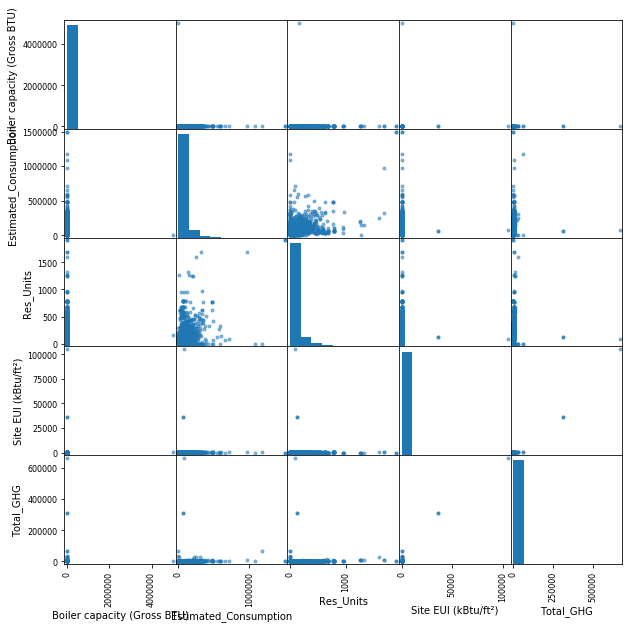

In [163]:
pd.scatter_matrix(oil_bmark, figsize=(10,10));

In [22]:
#dummy = pd.factorize(oil_bmark['Building Type'].values)[0]

In [81]:
dummy_df = oil_bmark[['Boiler capacity (Gross BTU)','Estimated_Consumption','Res_Units','Site EUI (kBtu/ft²)']]

## Add Fuel Type

In [82]:
dummy_df.head()

,Boiler capacity (Gross BTU),Estimated_Consumption,Res_Units,Site EUI (kBtu/ft²)
0,4.2,32000.0,68.0,105.6
1,4.1,41063.0,60.0,99.6
2,10.4,86000.0,168.0,107.4
3,8.4,82125.0,36.0,55.2
4,3.4,9072.0,41.0,97.3


In [140]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(dummy_df.values, 
                                                            oil_bmark['Total_GHG'], test_size=0.3, random_state=99)

In [153]:
clf =  ensemble.RandomForestRegressor(max_depth=5, random_state=100).fit(X_train, y_train)
clf.score(X_test, y_test)

0.83921606344003774

In [152]:
#clf =  ensemble.GradientBoostingRegressor(max_depth=5, random_state=100).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [154]:
pred = clf.predict(dummy_df.values)

In [242]:
len(oil_bmark), len(pred)

(2790, 2790)

In [257]:
oil_bmark['Predicted_GHG'] = pred

Text(0.5,1,'Log Transformed Correlation Between Predicted and Observed GHG Emissions')

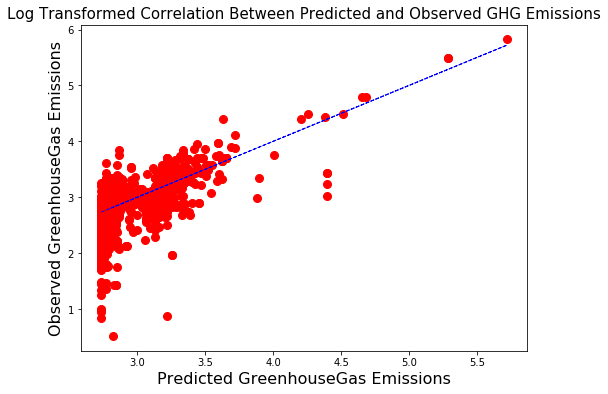

In [267]:
pl.figure(figsize = (8,6))
pl.plot(np.log10(pred),np.log10(oil_bmark['Total_GHG']),'or', markersize = 8) # Plot the observed value, linestyle = 'or', red dots
pl.plot(np.log10(pred),np.log10(pred),'--b', linewidth = 1)                 # Plot the predicted value, blue dashed line
#pl.xlim(0,400000)
#pl.ylim(0,400000)
# Plot setting
pl.xlabel('Predicted GreenhouseGas Emissions', fontsize = 16)
pl.ylabel('Observed GreenhouseGas Emissions', fontsize = 16)
pl.title('Log Transformed Correlation Between Predicted and Observed GHG Emissions', fontsize=15)

In [245]:
shp = gpd.GeoDataFrame.from_file(path+'/ZIP_CODE_040114.shp')
shp.ZIPCODE = shp.ZIPCODE.astype(float)
shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213.0,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212.0,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225.0,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218.0,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [258]:
oil_shp = pd.merge(oil_bmark, shp, left_on=oil_bmark['Zip Code'], right_on=shp.ZIPCODE)

In [261]:
oil_shp = gpd.GeoDataFrame(oil_shp)

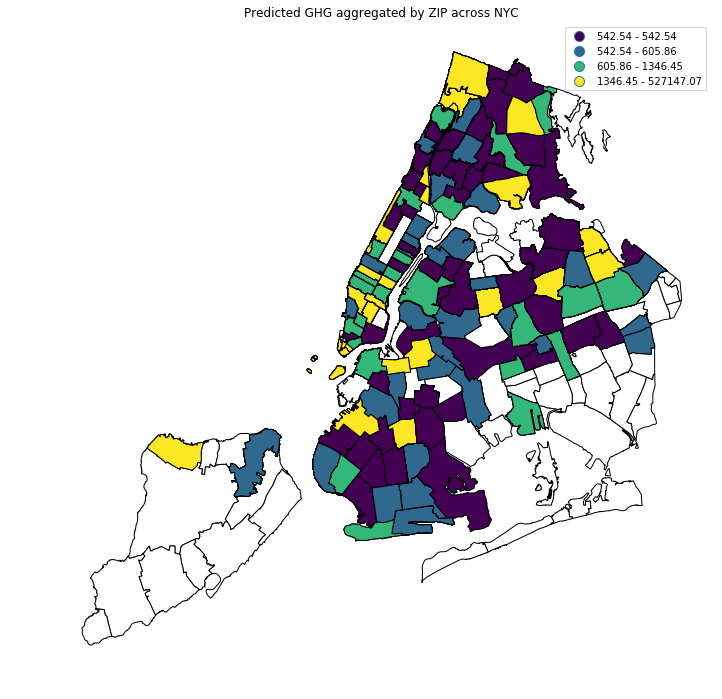

In [266]:
ax= shp.plot(color='w', edgecolor='k', figsize=(12,12))
oil_shp.plot(ax=ax, column='Predicted_GHG', edgecolor='k', cmap='viridis', figsize=(12,12), scheme='quantiles', legend=True)
ax.axis('off')
ax.set_title('Predicted GHG aggregated by ZIP across NYC', fontsize=20);

## Dummy Analysis

In [165]:
shp = gpd.GeoDataFrame.from_file(path+'/ZIP_CODE_040114.shp')

In [177]:
shp.ZIPCODE = shp.ZIPCODE.astype(float)

In [178]:
shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213.0,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212.0,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225.0,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218.0,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [170]:
geo_data.head()

,"BBL (Borough, Block and Lot)",Postcode,Latitude,Longitude,Census Tract,BIN,Boiler capacity (Gross BTU),Age range of boiler,Burner Model,Primary Fuel,...,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,1.007910e+09,NaN,NaN,NaN,NaN,NaN,2.8,31 to 35 years old,INDUSTRIAL COMBUSTION MEG-34S,#6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.012440e+09,NaN,NaN,NaN,NaN,NaN,14.0,26 to 30 years old,ICI DEG 175 P,#6,...,Multifamily Housing,76.1,Not Available,Not Available,14013371.4,Not Available,Not Available,1393.5,1082.0,311.5
2,2.025080e+09,NaN,NaN,NaN,NaN,NaN,2.8,Over 50 years,HEV-E-OIL AL4C,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.025080e+09,NaN,NaN,NaN,NaN,NaN,1.7,11 to 15 years old,ICI MMG 22,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.029900e+09,10460.0,40.835731,-73.886595,161.0,2010678.0,2.6,26 to 30 years old,HEV-E-OIL AMG 4 3/4,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
geo_shp = pd.merge(shp, geo_data, left_on=shp.ZIPCODE, right_on=geo_data['Zip Code'])

In [182]:
geo_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,86.6,Not Available,Not Available,Not Available,Not Available,Not Available,1422.1,597.9,824.2
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,128.2,Not Available,Not Available,Not Available,Not Available,Not Available,1701.6,753.8,947.8
2,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,147.8,Not Available,Not Available,Not Available,Not Available,Not Available,592.2,168.0,424.3
3,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,136.9,Not Available,Not Available,Not Available,Not Available,Not Available,1901.1,859.5,1041.6
4,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,85.6,Not Available,Not Available,Not Available,Not Available,Not Available,710.6,183.0,527.6


In [188]:
geo_shp.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'BBL (Borough, Block and Lot)', 'Postcode', 'Latitude',
       'Longitude', 'Census Tract', 'BIN', 'Boiler capacity (Gross BTU)',
       'Age range of boiler', 'Burner Model', 'Primary Fuel',
       'Total Estimated Cosumption - High Estimate (Gallons) ',
       'Needs to comply with Greener Greater Buildings Laws?', 'Building Type',
       'Number of residential units', 'NYC Borough, Block and Lot (BBL)',
       'Reported NYC Building Identification Numbers (BINs)', 'Zip Code',
       'Primary Property Type - Self Selected', 'Site EUI (kBtu/ft²)',
       'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)', 'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metr

In [202]:
boiler = pd.read_csv(path+'/BoilerAirData_2013.csv')

In [203]:
uhf = gpd.GeoDataFrame.from_file(path+'/Shapefiles/UHF_42_DOHMH.shp')

In [204]:
boiler_PM = boiler[boiler.name=='Boiler Emissions- Total PM2.5 Emissions']

In [205]:
uhf_pm = pd.merge(uhf, boiler_PM, left_on='UHFCODE', right_on='geo_entity_id')

In [206]:
uhf_pm.head()

,UHFCODE,UHFNAME,BOROUGH,UHF,ALTCHPUHF,CHSUHF,SHAPE_Leng,SHAPE_Area,geometry,﻿indicator_data_id,indicator_id,name,Measure,geo_type_name,geo_entity_id,geo_entity_name,year_description,data_valuemessage,Unnamed: 9
0,101.0,Kingsbridge - Riverdale,Bronx,101.0,Kingsbridge and Riverdale,101 Kingsbridge,57699.155405,1.332914e+08,"POLYGON ((1017992.893616721 269222.9643171281,...",130445,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,101,Kingsbridge - Riverdale,2013,2.0,NaN
1,102.0,Northeast Bronx,Bronx,102.0,the Northeast Bronx,102 Northeast Bronx,88219.321955,1.813708e+08,"POLYGON ((1025012.990336925 270794.2603199333,...",130446,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,102,Northeast Bronx,2013,0.3,NaN
2,103.0,Fordham - Bronx Park,Bronx,103.0,Fordham and Bronx Park,103 Fordham - Bronx Pk,59711.872129,1.407724e+08,"POLYGON ((1023994.479497686 261065.967421189, ...",130447,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,103,Fordham - Bronx Pk,2013,3.0,NaN
3,104.0,Pelham - Throgs Neck,Bronx,104.0,the Southeast Bronx,104 Pelham,250903.368668,3.865737e+08,(POLYGON ((1035076.590206906 252950.8257974088...,130448,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,104,Pelham - Throgs Neck,2013,0.5,NaN
4,105.0,Crotona - Tremont,Bronx,105.0,the Central Bronx,105 Crotona-Tremont,66676.088852,1.068978e+08,"POLYGON ((1007916.255088538 252530.7523161173,...",130449,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,105,Crotona -Tremont,2013,2.0,NaN


In [189]:
type(geo_shp), type(uhf_pm)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

In [207]:
geo_shp = geo_shp.to_crs(epsg=2263)
uhf_pm = uhf_pm.to_crs(epsg=2263)

In [227]:
merged = sjoin(geo_shp, uhf_pm, how='left',op='intersects')

In [228]:
merged.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,﻿indicator_data_id,indicator_id,name,Measure,geo_type_name,geo_entity_id,geo_entity_name,year_description,data_valuemessage,Unnamed: 9
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130480.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,0.1,NaN
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130480.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,0.1,NaN
2,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN


In [229]:
merged = merged.dropna(subset=['data_valuemessage'])

In [270]:
merged.reset_index(inplace=True)

In [271]:
merged.head()

,index,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,...,﻿indicator_data_id,indicator_id,name,Measure,geo_type_name,geo_entity_id,geo_entity_name,year_description,data_valuemessage,Unnamed: 9
0,0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN
1,0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,...,130480.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,0.1,NaN
2,1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN
3,1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,...,130480.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,0.1,NaN
4,2,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN


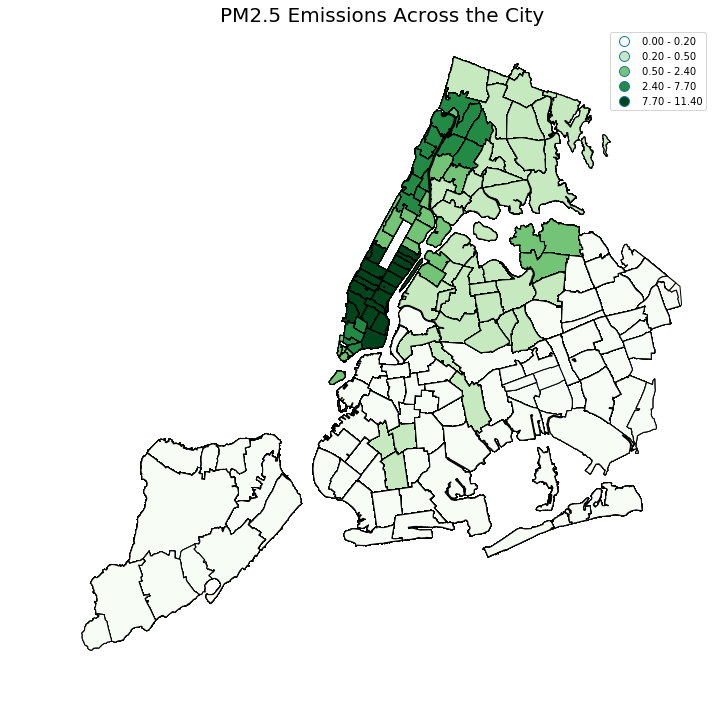

In [282]:
ax = merged.plot(column='data_valuemessage',edgecolor='k', figsize=(12,12), 
                 scheme='quantiles',cmap='Greens', legend=True)
ax.axis('off')
pl.title('PM2.5 Emissions Across the City', fontsize=20);

In [269]:
pd.read_csv?

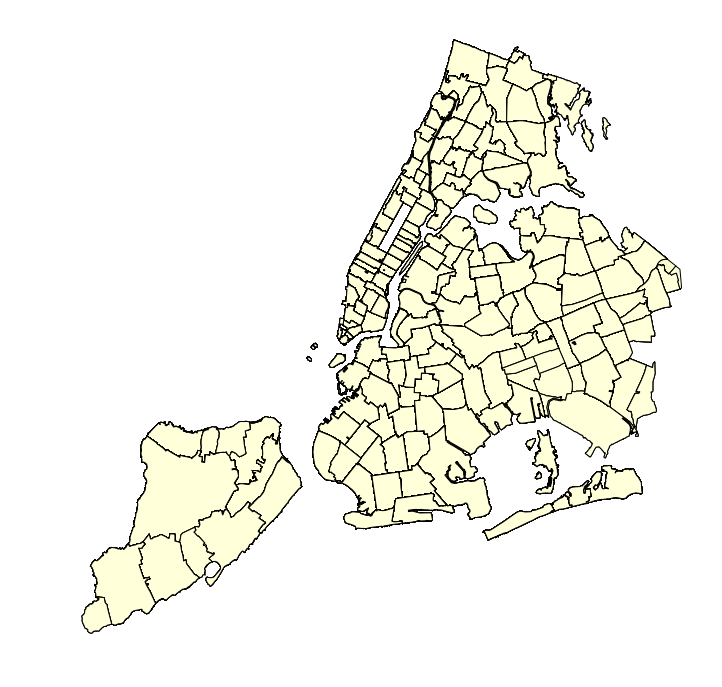

In [277]:
geo_shp.plot(column='Site EUI (kBtu/ft²)',edgecolor='k', figsize=(12,12), cmap='YlGnBu')
pl.axis('off');